In [1]:
import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")


!pip install mediapipe
# Clean up the notebook
clean_notebook()


Notebook cleaned.


In [1]:
from matplotlib import pyplot as plt
import cv2
import mediapipe as mp
import numpy as np

# Initialize Mediapipe Selfie Segmentation
mp_selfie_segmentation = mp.solutions.selfie_segmentation
segmenter = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

I0000 00:00:1732781522.596743 2153581 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Max
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1732781522.598503 2153711 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


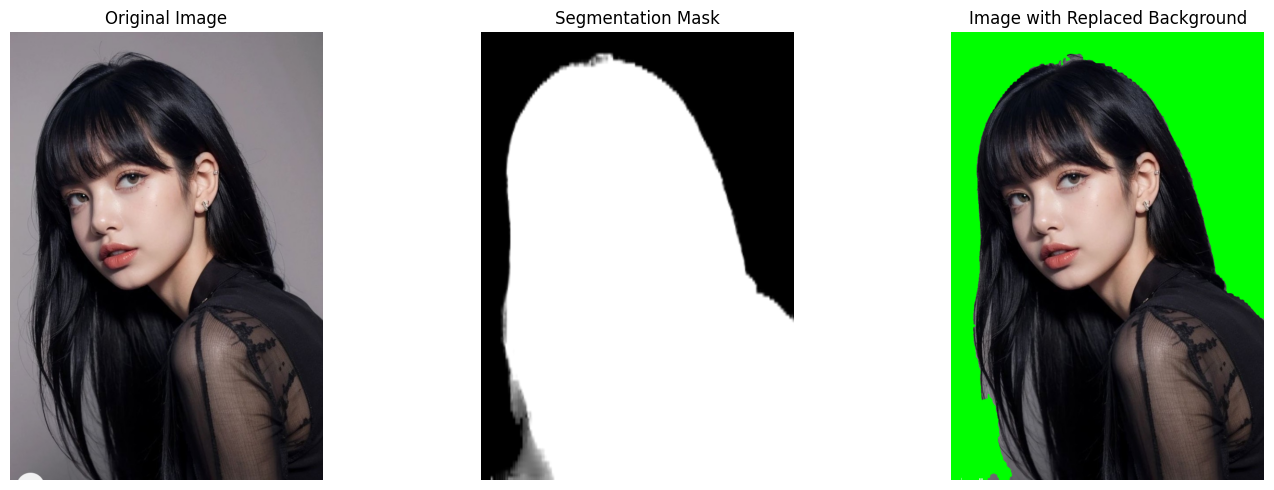

In [2]:


# Load and process the image
image = cv2.imread(".././/images/lisa.jpg")  # Replace with your image path
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = segmenter.process(image_rgb)
segmentation_mask = results.segmentation_mask

# Create a binary mask
mask = segmentation_mask > 0.5

# Replace background
background = np.ones_like(image) * [0, 255, 0]  # Green background
output_image = np.where(mask[..., None], image_rgb, background)

# Plot the original and segmented images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(segmentation_mask, cmap='gray')
axs[1].set_title("Segmentation Mask")
axs[1].axis('off')

axs[2].imshow(output_image)
axs[2].set_title("Image with Replaced Background")
axs[2].axis('off')

plt.tight_layout()




In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-c65e10b9-6854-5af7-b015-f5f0c73639d1"
# Display the value of cuda_device
print("CUDA device:", os.environ["CUDA_VISIBLE_DEVICES"] )

In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

# Load a pre-trained DeepLabV3 model
model = torch.hub.load('pytorch/vision:v0.13.1', 'deeplabv3_resnet101', pretrained=True)
model.eval()

# Define a mapping for the custom classes
# DeepLabV3 provides a general set of 21 classes, but you need to map these classes to your custom ones
custom_classes = {
    0: "background",
    1: "hair",
    2: "body-skin",
    3: "face-skin",
    4: "clothes",
    5: "others"
}

# A mapping of DeepLabV3's classes to custom classes (Example: map 'person' to face-skin, clothes, etc.)
deeplab_to_custom_mapping = {
    0: 0,  # background
    15: 2,  # body-skin (DeepLab's person class)
    16: 3,  # face-skin (requires finer separation if custom-trained)
    17: 4,  # clothes
    18: 1,  # hair
    # Map other classes to 'others' if they are not relevant
}

# Function to preprocess the input image
def preprocess_image(image_path):
    input_image = Image.open(image_path).convert("RGB")
    preprocess = T.Compose([
        T.Resize((512, 512)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return preprocess(input_image).unsqueeze(0), input_image

# Segment the image
def segment_image(model, input_tensor):
    with torch.no_grad():
        output = model(input_tensor)['out'][0]
        output_predictions = output.argmax(0).numpy()
    return output_predictions

# Map DeepLabV3's output to custom classes
def map_to_custom_classes(output_predictions, mapping):
    mapped_output = np.zeros_like(output_predictions)
    for dl_class, custom_class in mapping.items():
        mapped_output[output_predictions == dl_class] = custom_class
    return mapped_output
from PIL import Image

def visualize_segmentation(input_image, segmented_output, class_names):
    # Resize the segmented output to match input image dimensions
    original_size = input_image.size
    resized_segmented_output = np.array(
        Image.fromarray(segmented_output.astype(np.uint8)).resize(original_size, Image.NEAREST)
    )

    input_image = np.array(input_image)
    fig, axs = plt.subplots(1, len(class_names) + 1, figsize=(20, 5))
    
    axs[0].imshow(input_image)
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    
    for class_id, class_name in class_names.items():
        mask = resized_segmented_output == class_id
        class_image = np.zeros_like(input_image)
        class_image[mask] = input_image[mask]
        axs[class_id + 1].imshow(class_image)
        axs[class_id + 1].set_title(class_name)
        axs[class_id + 1].axis('off')
    
    plt.tight_layout()
    plt.show()


# Main execution
image_path = ".././/images/lisa.jpg"  # Replace with your image path
input_tensor, input_image = preprocess_image(image_path)
output_predictions = segment_image(model, input_tensor)
custom_segmented_output = map_to_custom_classes(output_predictions, deeplab_to_custom_mapping)

# Visualize the results
visualize_segmentation(input_image, custom_segmented_output, custom_classes)


Downloading: "https://github.com/pytorch/vision/zipball/v0.13.1" to /Users/tuchsanai/.cache/torch/hub/v0.13.1.zip
/opt/anaconda3/envs/torch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/torch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /Users/tuchsanai/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


In [10]:
import cv2
import mediapipe as mp
import numpy as np
from matplotlib import pyplot as plt


mp_selfie_segmentation = mp.solutions.selfie_segmentation
segmenter = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)


W0000 00:00:1732778802.146127    5648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [11]:
image = cv2.imread(".././/images/lisa.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = segmenter.process(image_rgb)
segmentation_mask = results.segmentation_mask


# Apply the combined mask to the original image
hair_segmented = cv2.bitwise_and(image, image, mask=hair_mask )

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Hair Segmentation")
plt.imshow(cv2.cvtColor(hair_segmented, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()



In [13]:
hair_mask

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)

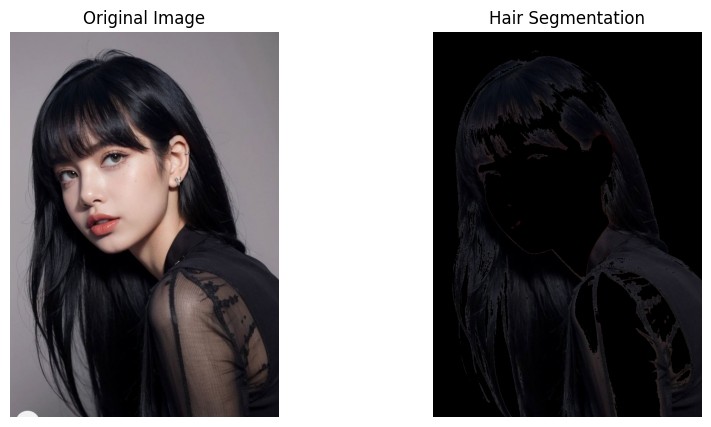

In [14]:
# Create a binary mask for the person
person_mask = segmentation_mask > 0.5

# Convert the image to HSV color space
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define HSV range for hair color (this range may need adjustment)
lower_hair = np.array([0, 0, 0])
upper_hair = np.array([179, 255, 50])

# Create a hair mask based on the HSV range
hair_mask = cv2.inRange(image_hsv, lower_hair, upper_hair)

# Combine the person mask and hair mask
combined_mask = cv2.bitwise_and(person_mask.astype(np.uint8) * 255, hair_mask)

# Apply the combined mask to the original image
hair_segmented = cv2.bitwise_and(image, image, mask=hair_mask )

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Hair Segmentation")
plt.imshow(cv2.cvtColor(hair_segmented, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


W0000 00:00:1732778948.591801    5689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


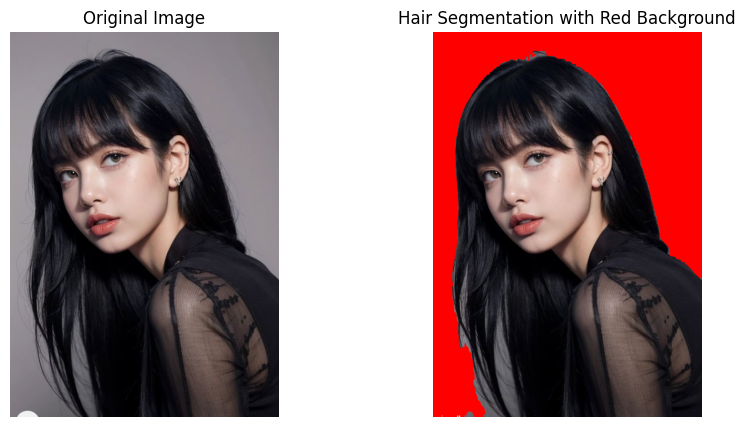

In [15]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import mediapipe as mp

# Initialize MediaPipe Selfie Segmentation
mp_selfie_segmentation = mp.solutions.selfie_segmentation
segmenter = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

# Load and process the image
image = cv2.imread(".././/images/lisa.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = segmenter.process(image_rgb)
segmentation_mask = results.segmentation_mask

# Create a binary mask where hair is segmented
hair_mask = segmentation_mask > 0.5

# Create a red background image
red_background = np.full_like(image_rgb, [255, 0, 0])  # Red in RGB

# Combine the hair region with the red background
output_image = np.where(hair_mask[..., None], image_rgb, red_background)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_rgb)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Hair Segmentation with Red Background")
plt.imshow(output_image)
plt.axis("off")
plt.show()
